In [40]:
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

# 0. Load data 

In [2]:
from patrec.utils.visuals import plot_series
from patrec.utils.files_helper import JSON_Handler, YAML_Config

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
# from patrec.clustering.metrics import Clustering_Metrics_Evaluator

In [3]:
# univariate
# beef_dataset = JSON_Handler('data/sub_UCR_bench/Beef/X_full_sample.json')
beef_dataset = JSON_Handler('data/sub_UCR_bench/Trace/X_full_sample.json')
# ecg200_dataset = JSON_Handler('data/sub_UCR_bench/ECG200/X_full_sample.json')
# MP_dataset = JSON_Handler('data/sub_UCR_bench/MelbournePedestrian/X_full_sample.json')
# ecg5000_dataset = JSON_Handler('data/sub_UCR_bench/ECG5000/X_full_sample.json')
# DG_dataset = JSON_Handler('data/sub_UCR_bench/DucksAndGeese/X_full_sample.json')
# abh_dataset = JSON_Handler('data/sub_UCR_bench/AbnormalHeartbeat/X_full_sample.json') #BinaryHeartbeat 

read data from data/sub_UCR_bench/Trace/X_full_sample.json


In [41]:
for name in ['Beef', 'Trace', 'ECG200', 'MelbournePedestrian', 'ECG5000', 'DucksAndGeese', 'AbnormalHeartbeat']:
    dataset = JSON_Handler(f'data/sub_UCR_bench/{name}/X_full_sample.json')

read data from data/sub_UCR_bench/Beef/X_full_sample.json
read data from data/sub_UCR_bench/Trace/X_full_sample.json
read data from data/sub_UCR_bench/ECG200/X_full_sample.json


FileNotFoundError: JSON file not found: data/sub_UCR_bench/ECG200/X_full_sample.json

In [4]:
# multivariate 
# BS_dataset = JSON_Handler('data/sub_UCR_bench/BasicMotions/X_full_sample.json')

# 1. sklearn clustering

In [5]:
X,y = np.asarray(beef_dataset.data['data']).squeeze(1), np.asarray(beef_dataset.data['labels'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

## functions

In [ ]:
from sklearn.metrics import (
    silhouette_score,
    normalized_mutual_info_score,
    adjusted_rand_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    confusion_matrix
)
from scipy.optimize import linear_sum_assignment
from typing import Literal


def map_clusters(y_true, y_pred, filter='pred'):
    """Сопоставляет истинные метки с предсказанными кластерами."""
    
    unique_true = np.unique(y_true)
    unique_pred = np.unique(y_pred)
    
    if filter == "pred":
        conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_pred)
    elif filter == "true":
        conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_true)
    #
    cost_matrix = -conf_matrix.copy()
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {int(true): int(pred) for true, pred in zip(col_ind, row_ind)}
    # 
    y_pred_convert = np.asarray([mapping[val] for val in y_pred])
    
    return y_pred_convert, mapping, conf_matrix 


class Clustering_Metrics_Evaluator:
    def __init__(self, metrics=None, y_true=None, y_pred=None, X_feat=None):
        self.metrics = metrics or [
            "silhouette", "nmi", "ari", "accuracy", "precision", "recall", "f1",
            "calinski_harabasz_score", "davies_bouldin_score"
        ]
        self._validate_input(y_true, y_pred, X_feat)     
        self.pred_convert, self.conf_mtx, self.mapping = self._map_clusters()
           
    def _validate_input(self, y_true, y_pred, X_feat):
        """Проверяет корректность входных данных."""
        if y_true is None or y_pred is None:
            raise ValueError("y_true и y_pred должны быть предоставлены.")
        if len(y_true) != len(y_pred):
            raise ValueError(f"Размеры y_true ({len(y_true)}) и y_pred ({len(y_pred)}) не совпадают.")
        
        if X_feat:
            if X_feat.shape[1] > 1:
                raise ValueError("3D data and it's Incorrect")
            if len(X_feat.shape) == 3:
                X_feat = X_feat.squeeze(1)
        
        self.X_feat = X_feat
        self.y_true = y_true 
        self.unique_true = np.unique(self.y_true)
        self.y_pred = y_pred
        self.unique_pred = np.unique(self.y_pred)
        
        if len(self.unique_pred) < len(self.unique_true):
            print(f"Предупреждение: Количество кластеров ({len(self.unique_pred)}) < количество классов ({len(self.unique_true)}).")

    def _map_clusters(self, filter_by:Literal['pred', 'true']='true'):
        return map_clusters(self.y_true, self.y_pred, filter_by)
    
    def _norm_conf_mtx(self):
        """Преобразует матрицу ошибок в проценты."""
        total = self.conf_mtx.sum()
        return self.conf_mtx / total * 100 if total > 0 else self.conf_mtx

    # def _():
    
    def _get_cluster_analysis(self, y_true, y_pred, X, mapping):
        """Анализирует структуру кластеров и возвращает информацию о каждом из них."""
        results = {}
        unique_clusters = np.unique([mapping[y] for y in y_pred])
        for cluster_id in unique_clusters:
            indices = np.where([mapping[y] == cluster_id for y in y_pred])[0]
            if len(indices) == 0:
                continue
            cluster_data = X[indices]
            true_labels = y_true[indices]
            # Преобразуем y_pred в предсказанные метки с учётом маппинга
            mapped_y_pred = np.array([mapping[y] for y in y_pred])
            pred_labels = mapped_y_pred[indices]
            correct = np.sum(true_labels == pred_labels)
            incorrect = len(indices) - correct
            wrong_indices = np.where(pred_labels != true_labels)[0]
            results[cluster_id] = {
                "total_samples": len(indices),
                "correct": correct,
                "incorrect": incorrect,
                "wrong_samples": {
                    "indices": indices[wrong_indices],
                    "data": cluster_data[wrong_indices],
                    "true_labels": true_labels[wrong_indices],
                    "predicted_labels": pred_labels[wrong_indices]
                }
            }
        return results

    def evaluate(self, y_true, y_pred, X=None):
        results = {}
        unique_clusters = np.unique(y_pred)
        results["n_clusters"] = len(unique_clusters)
        if "silhouette" in self.metrics and X is not None and len(unique_clusters) > 1:
            try:
                results["silhouette"] = silhouette_score(X, y_pred)
            except:
                results["silhouette"] = None
        else:
            results["silhouette"] = None
        if "calinski_harabasz_score" in self.metrics and X is not None and len(unique_clusters) > 1:
            try:
                results["calinski_harabasz_score"] = calinski_harabasz_score(X, y_pred)
            except:
                results["calinski_harabasz_score"] = None
        else:
            results["calinski_harabasz_score"] = None
        if "davies_bouldin_score" in self.metrics and X is not None and len(unique_clusters) > 1:
            try:
                results["davies_bouldin_score"] = davies_bouldin_score(X, y_pred)
            except:
                results["davies_bouldin_score"] = None
        else:
            results["davies_bouldin_score"] = None
        if y_true is not None:
            mapping = self._create_mapping(y_true, y_pred)
            if "nmi" in self.metrics:
                results["nmi"] = normalized_mutual_info_score(y_true, y_pred)
            if "ari" in self.metrics:
                results["ari"] = adjusted_rand_score(y_true, y_pred)
            if "accuracy" in self.metrics:
                results["accuracy"] = accuracy_score(y_true, [mapping[y] for y in y_pred])
            if "precision" in self.metrics:
                results["precision"] = precision_score(y_true, [mapping[y] for y in y_pred], average='macro', zero_division=0)
            if "recall" in self.metrics:
                results["recall"] = recall_score(y_true, [mapping[y] for y in y_pred], average='macro', zero_division=0)
            if "f1" in self.metrics:
                results["f1"] = f1_score(y_true, [mapping[y] for y in y_pred], average='macro', zero_division=0)
        else:
            for m in ["nmi", "ari", "accuracy", "precision", "recall", "f1"]:
                if m in self.metrics:
                    results[m] = None
        return results

    def get_confusion_matrix(self, y_true, y_pred):
        """Возвращает матрицу ошибок для кластеров."""
        self._validate_input(y_true, y_pred)
        return confusion_matrix(y_true, y_pred)

    def get_tpr_fpr_tnr_fnr(self, y_true, y_pred):
        """Вычисляет TP, FP, TN, FN для каждого класса."""
        self._validate_input(y_true, y_pred)
        cm = self.get_confusion_matrix(y_true, y_pred)
        n_classes = cm.shape[0]
        tpr = []
        fpr = []
        tnr = []
        fnr = []
        for i in range(n_classes):
            tp = cm[i, i]
            fp = sum(cm[:, i]) - tp
            fn = sum(cm[i, :]) - tp
            tn = sum(sum(cm)) - (tp + fp + fn)
            tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
            fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
            tnr.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
            fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
        return {
            "TPR": tpr,
            "FPR": fpr,
            "TNR": tnr,
            "FNR": fnr
        }

    def find_misclassified_samples(self, y_true, y_pred, X=None):
        """
        Находит экземпляры, которые были присвоены в неправильные кластеры.
        Возвращает информацию о каждом неправильно классифицированном образце,
        включая оригинальный класс, предсказанный кластер и сопоставленный класс.
        """
        if y_true is None or X is None:
            raise ValueError("y_true и X должны быть предоставлены.")
        
        # Сопоставляем кластеры
        mapped_pred = self._map_clusters(y_true, y_pred)
        
        # Находим индексы, где предсказание не совпадает с истиной
        misclassified_indices = np.where(mapped_pred != y_true)[0]
        
        # Формируем список неправильно классифицированных точек
        results = []
        for idx in misclassified_indices:
            original_class = y_true[idx]
            predicted_cluster = y_pred[idx]
            mapped_class = mapped_pred[original_class]
            results.append({
                "index": idx,
                "original_class": original_class,
                "predicted_cluster": predicted_cluster,
                "mapped_class": mapped_class,
                "X": X[idx]
            })
        
        return results

    def analyze_cluster_structure(self, y_true, y_pred, X=None):
        """Анализирует структуру кластеров."""
        self._validate_input(y_true, y_pred)
        mapping = self._create_mapping(y_true, y_pred)
        return self._get_cluster_analysis(y_true, y_pred, X, mapping)

    def get_mapping(self, y_true, y_pred):
        """Возвращает словарь, который показывает, как истинные метки были сопоставлены с предсказанными кластерами."""
        self._validate_input(y_true, y_pred)
        return self._create_mapping(y_true, y_pred)

    def analyze_confusion_matrix(
        self,
        y_true, 
        y_pred, 
        X=None, 
        show_percentage=True, 
        filter_class=None, 
        by_original=True
    ):
        """
        Анализирует матрицу ошибок.
        
        Args:
            y_true (np.ndarray): Истинные метки.
            y_pred (np.ndarray): Предсказанные метки.
            X (np.ndarray): Матрица признаков.
            show_percentage (bool): Перевести значения в проценты.
            filter_class (int): Фильтр по оригинальному классу.
            by_original (bool): Фильтровать по оригинальным меткам (True) или предсказанным (False).
        
        Returns:
            dict: Словарь с анализом матрицы ошибок.
        """
        self._validate_input(y_true, y_pred)
        
        # Получаем маппинг
        mapping = self._map_clusters(y_true, y_pred)
        
        # Получаем исходную матрицу ошибок
        cm = confusion_matrix(y_true, y_pred)
        
        # Переводим в проценты
        if show_percentage:
            cm = self._convert_to_percentages(cm)
        
        # Если нужно фильтровать по оригинальному или предсказанному классу
        if filter_class is not None:
            if by_original:
                # Фильтруем по оригинальному классу
                filtered_cm = cm[filter_class]
            else:
                # Фильтруем по предсказанному классу
                idx = np.argmax(cm, axis=0)
                filtered_cm = cm[:, idx == filter_class]
            cm = filtered_cm
        
        # Получаем индексы неправильно классифицированных
        misclassified_indices = self._get_misclassified_indices(y_true, y_pred, mapping)
        
        # Получаем аналитику по кластерам
        cluster_analysis = self._get_cluster_analysis(y_true, y_pred, X, mapping)
        
        return {
            "mapping": mapping,
            "confusion_matrix": cm,
            "misclassified_indices": misclassified_indices,
            "cluster_analysis": cluster_analysis
        }

## 1.1 partitioning

In [7]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from patrec.utils.files_helper import JSON_Handler, Format1_loader
from patrec.clustering.metrics import Clustering_Metrics_Evaluator
from patrec.clustering.partitioning_clustering import Sklearn_KMeans
from patrec.clustering.base import Base_Clustering_Model


# 2. Предобработка данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
print(X_scaled.shape)

# 3. Кластеризация KMeans

kmeans = Sklearn_KMeans()
kmeans.load_model_parameters(n_clusters=4)  # Trace имеет 4 класса
train_labels, _ = kmeans.fit_predict(X_scaled)

# 4. Оценка результатов
evaluator = Clustering_Metrics_Evaluator(y_true=y_train, y_pred=train_labels, X_feat=X_scaled)
metrics = evaluator.evaluate(y_train, train_labels, X_scaled)

# 5. Сохранение результатов с помощью JSON_Handler
results = {
    "dataset": "Trace",
    "parameters": kmeans.default_params,
    "metrics": metrics,
    "cluster_centers": kmeans.get_cluster_centers().tolist(),
    "inertia": kmeans.get_inertia()
}

# Сохранение в JSON
json_handler = JSON_Handler(filepath=".temp/kmeans/trace_kmeans_results.json", data=results)
print("Результаты сохранены в:", json_handler.filepath)

# 6. Вывод основных метрик
print("\nОсновные метрики кластеризации:")
print(f"NMI: {metrics['nmi']:.4f}")
print(f"ARI: {metrics['ari']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Silhouette: {metrics['silhouette']:.4f}")

(120, 275)
{2: 0, 1: 1, 0: 2, 3: 3}
save data to .temp/kmeans/trace_kmeans_results.json
Результаты сохранены в: .temp/kmeans/trace_kmeans_results.json

Основные метрики кластеризации:
NMI: 0.5109
ARI: 0.3429
Accuracy: 0.5833
Silhouette: 0.3782


In [6]:
from patrec.clustering.base import *
from patrec.clustering.opt import *
from patrec.clustering.partitioning_clustering import Sklearn_KMeans


Best number of clusters: 2
Best score: 0.6015


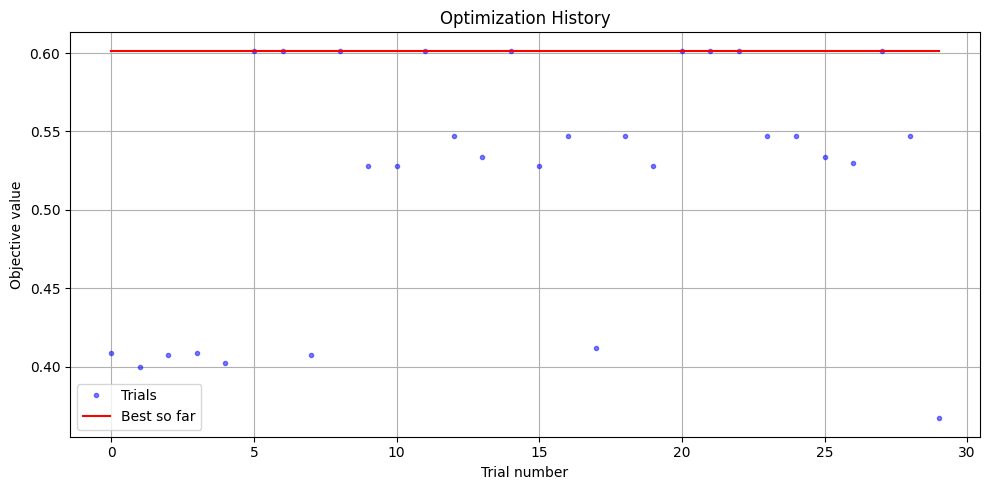

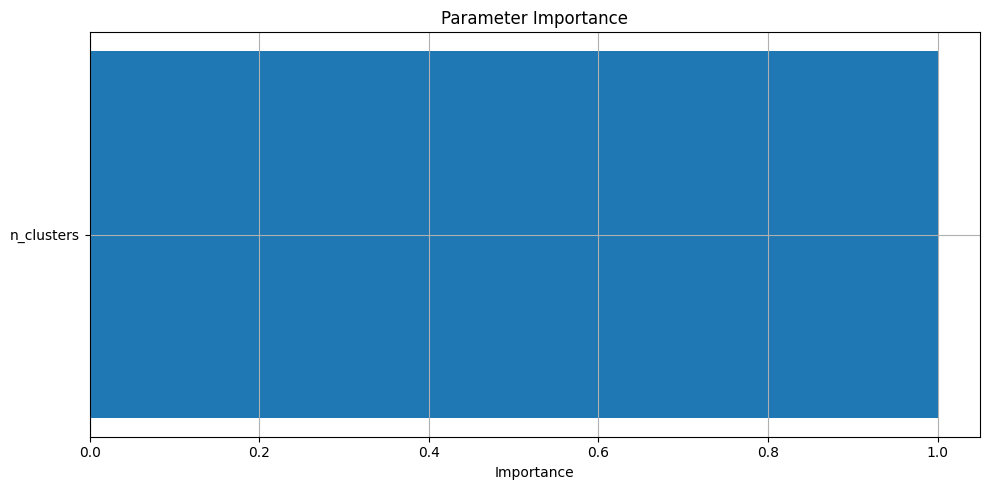

In [7]:
model = Sklearn_KMeans()
optimizer = ClusterOptimizerFactory.create('optuna', metric='silhouette')
result = optimizer.optimize(model, X_train, n_clusters_range=(2, 10), n_trials=30)

print(f"Best number of clusters: {result['best_n_clusters']}")
print(f"Best score: {result['best_score']:.4f}")

# Визуализация
fig1 = plot_optimization_history(result['study'])
fig2 = plot_parameter_importance(result['study'])



/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [5]
  warnings.warn(
/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [3]
  warnings.warn(
/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [2]
  warnings.warn(
/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [6]
  warnings.warn(
/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The 

Best number of clusters: 2
Best score: 235.4170


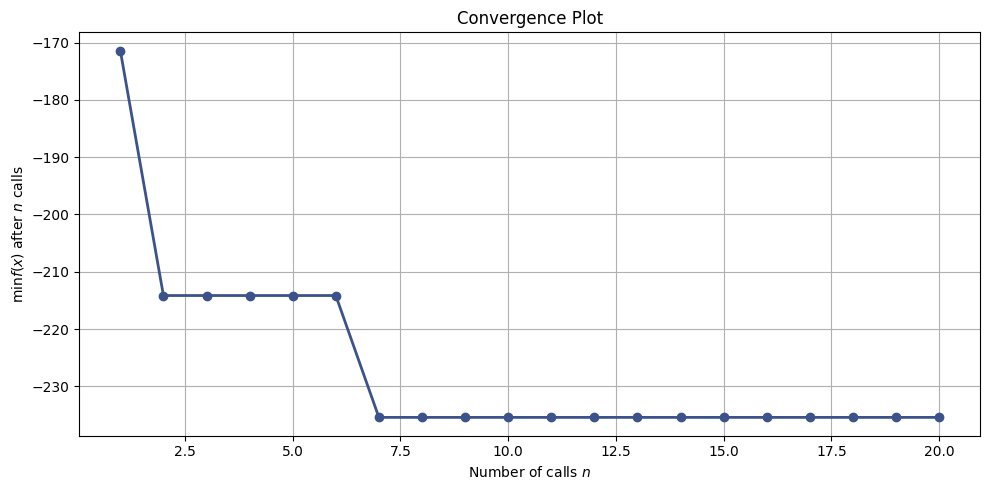

In [8]:
model = Sklearn_KMeans()
optimizer = ClusterOptimizerFactory.create('skopt', metric='calinski_harabasz')
result = optimizer.optimize(model, X_train, n_clusters_range=(2, 8), n_calls=20)

print(f"Best number of clusters: {result['best_n_clusters']}")
print(f"Best score: {result['best_score']:.4f}")

# Визуализация
fig = plot_skopt_convergence(result)

Clusters: 2, Score: 0.6176
Clusters: 3, Score: 0.9138
Clusters: 4, Score: 0.9195
Clusters: 5, Score: 0.9140
Clusters: 6, Score: 0.9741
Clusters: 7, Score: 0.9583
Clusters: 8, Score: 0.9700
Clusters: 9, Score: 0.9516
Clusters: 10, Score: 0.9724
Best number of clusters: 2
Best score: 0.6176


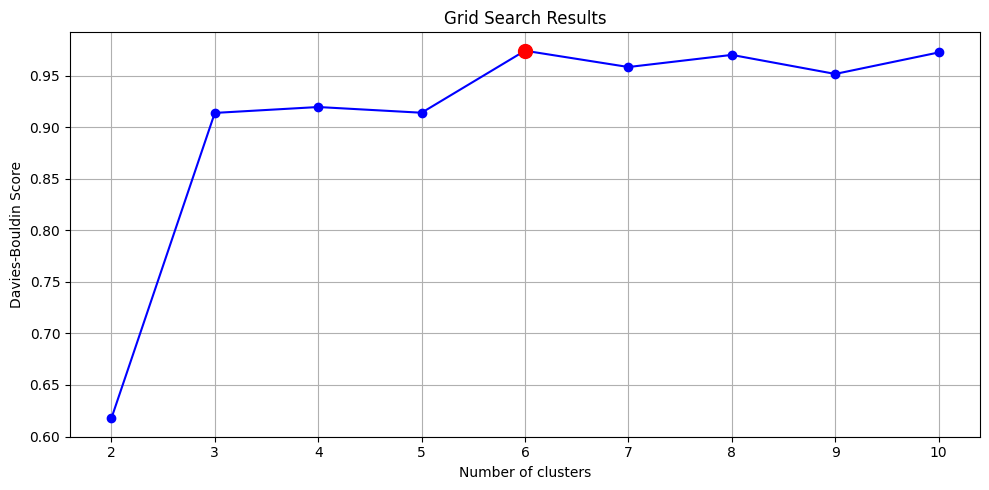

In [9]:
model = Sklearn_KMeans()
optimizer = ClusterOptimizerFactory.create('grid', metric='davies_bouldin')
result = optimizer.optimize(model, X_train, n_clusters_range=(2, 10), verbose=True)

print(f"Best number of clusters: {result['best_n_clusters']}")
print(f"Best score: {result['best_score']:.4f}")

# Визуализация
fig = plot_grid_search_history(result['history'], 'Davies-Bouldin Score')

In [10]:
result

{'best_n_clusters': 2,
 'best_score': 0.6176379771422624,
 'history': [{'n_clusters': 2, 'score': 0.6176379771422624},
  {'n_clusters': 3, 'score': 0.9137764146001923},
  {'n_clusters': 4, 'score': 0.919497372314514},
  {'n_clusters': 5, 'score': 0.9139524576227505},
  {'n_clusters': 6, 'score': 0.9740909014630942},
  {'n_clusters': 7, 'score': 0.958272266551135},
  {'n_clusters': 8, 'score': 0.9700364635588075},
  {'n_clusters': 9, 'score': 0.9515614573947916},
  {'n_clusters': 10, 'score': 0.9723961072332787}]}

In [ ]:
model =  Sklearn_KMeans()
model.load_model_parameters(**{'n_clusters':2})

y_pred, _ = model.fit_predict(X_train)
acl_an = ClusterAnalyzer(model)
_, mapping, _ = acl_an._map_clusters(y_true=y_train, y_pred=y_pred)
new_lbls = np.asarray([mapping[item] for item in y_pred])

print(silhouette_score(X_train, y_pred), normalized_mutual_info_score(y_train, y_pred), adjusted_rand_score(y_train, new_lbls))

visualize_cluster_errors(
    X_train=X_train,
    y_train=y_train,
    y_pred=y_pred,
    mapping=mapping,
    save_dir='.temp/kmeans/error_visualization_4',
    figsize=(12, 4),
    show_legend=True
)

visualize_cluster_composition(
    X=X_train,
    y_true=y_train,
    y_pred=y_pred,
    mapping=mapping,
    save_dir='.temp/kmeans/cluster_visualization_4',
    figsize=(12, 4),
    show_legend=True
)

True
0.3696912070260797 0.42691129988433957 0.20273660205245153
Saved: .temp/kmeans/error_visualization_4/class_0_cluster_2.png | Correct: 4, Errors: 23
Saved: .temp/kmeans/error_visualization_4/class_1_cluster_4.png | Correct: 0, Errors: 38
Saved: .temp/kmeans/error_visualization_4/class_2_cluster_5.png | Correct: 0, Errors: 29
Saved: .temp/kmeans/error_visualization_4/class_3_cluster_0.png | Correct: 8, Errors: 18
Saved: .temp/kmeans/cluster_visualization_4/cluster_0_composition.png | Total: 23 | Main class: 3 (8 samples)
Saved: .temp/kmeans/cluster_visualization_4/cluster_1_composition.png | Total: 11 | Main class: 7 (0 samples)
Saved: .temp/kmeans/cluster_visualization_4/cluster_2_composition.png | Total: 9 | Main class: 0 (4 samples)
Saved: .temp/kmeans/cluster_visualization_4/cluster_3_composition.png | Total: 10 | Main class: 4 (0 samples)
Saved: .temp/kmeans/cluster_visualization_4/cluster_4_composition.png | Total: 14 | Main class: 1 (0 samples)
Saved: .temp/kmeans/cluster_vis

In [73]:
model =  Sklearn_KMeans()
model.load_model_parameters(**{'n_clusters':2})

y_pred, _ = model.fit_predict(X_train)
acl_an = ClusterAnalyzer(model)
_, mapping, _ = acl_an._map_clusters(y_true=y_train, y_pred=y_pred)
new_lbls = np.asarray([mapping[item] for item in y_pred])

print(silhouette_score(X_train, y_pred), normalized_mutual_info_score(y_train, y_pred), adjusted_rand_score(y_train, new_lbls))


visualize_cluster_errors(
    X_train=X_train,
    y_train=y_train,
    y_pred=y_pred,
    mapping=mapping,
    save_dir='.temp/kmeans/error_visualization_2',
    figsize=(12, 4),
    show_legend=True
)

visualize_cluster_composition(
    X=X_train,
    y_true=y_train,
    y_pred=y_pred,
    mapping=mapping,
    save_dir='.temp/kmeans/cluster_visualization_2',
    figsize=(12, 4),
    show_legend=True    
)

False
0.601504513821442 0.668281568685256 0.5010511562718991
Saved: .temp/kmeans/error_visualization_2/class_0_cluster_2.png | Correct: 0, Errors: 27
Saved: .temp/kmeans/error_visualization_2/class_1_cluster_1.png | Correct: 38, Errors: 0
Saved: .temp/kmeans/error_visualization_2/class_2_cluster_0.png | Correct: 29, Errors: 0
Saved: .temp/kmeans/error_visualization_2/class_3_cluster_3.png | Correct: 0, Errors: 26
Saved: .temp/kmeans/cluster_visualization_2/cluster_0_composition.png | Total: 55 | Main class: 2 (29 samples)
Saved: .temp/kmeans/cluster_visualization_2/cluster_1_composition.png | Total: 65 | Main class: 1 (38 samples)


## 2.1 embeddings

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from ts2vec import TS2Vec
from umap import UMAP
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
import torch

class TimeSeriesClusteringPipeline:
    def __init__(self, dataset_name, n_clusters=None, embedding_dim=64):
        """
        Initialize the time series clustering pipeline.
        
        Args:
            dataset_name: Name of the dataset from UCR/UEA archive
            n_clusters: Number of clusters (if None, will use true labels to determine)
            embedding_dim: Dimension of the ts2vec embeddings
        """
        self.dataset_name = dataset_name
        self.n_clusters = n_clusters
        self.embedding_dim = embedding_dim
        self.scaler = TimeSeriesScalerMinMax()
        self.embedding_model = None
        self.kmeans = None
        
    def load_data(self):
        """Load dataset from UCR/UEA archive"""
        datasets = UCR_UEA_datasets()
        X_train, y_train, X_test, y_test = datasets.load_dataset(self.dataset_name)
        
        # Combine train and test for unsupervised learning
        self.X = np.concatenate([X_train, X_test])
        self.y = np.concatenate([y_train, y_test])
        
        # Determine n_clusters from labels if not specified
        if self.n_clusters is None:
            self.n_clusters = len(np.unique(self.y))
            
        print(f"Loaded dataset {self.dataset_name} with {len(self.X)} samples, "
              f"{self.X.shape[1]} timesteps, {self.X.shape[2]} dimensions, "
              f"and {self.n_clusters} clusters.")
        
    def preprocess_data(self):
        """Normalize and prepare time series data"""
        # Handle NaN values by forward filling
        self.X = np.where(np.isnan(self.X), np.nan_to_num(self.X, nan=0), self.X)
        
        # Normalize each time series independently
        n_samples, n_timesteps, n_features = self.X.shape
        self.X_normalized = np.asarray([(row - np.min(row))/(np.max(row)-np.min(row)) for row in self.X])
        # self.X_normalized = self.X_normalized.reshape(n_samples, n_timesteps, n_features)
        # np.zeros_like(self.X)
        
        # for i in range(n_samples):
        #     for j in range(n_features):
        #         ts = self.X[i, :, j]
        #         if np.all(ts == ts[0]):  # Constant series
        #             self.X_normalized[i, :, j] = ts
        #         else:
        #             self.X_normalized[i, :, j] = self.scaler.fit_transform(ts.reshape(-1, 1)).flatten()
                    
    def extract_embeddings(self, epochs=5, batch_size=8):
        """
        Extract fixed-length embeddings using ts2vec.
        
        Args:
            epochs: Number of training epochs
            batch_size: Batch size for training
        """
        # ts2vec expects shape (n_samples, n_timesteps, n_features)
        self.embedding_model = TS2Vec(
            input_dims=self.X_normalized.shape[-1],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            output_dims=self.embedding_dim,
            batch_size=batch_size
        )
        
        # Train the model (unsupervised)
        self.embedding_model.fit(
            self.X_normalized,
            n_epochs=epochs
        )
        
        # Extract embeddings
        self.embeddings = self.embedding_model.encode(self.X_normalized, encoding_window='full_series')
        
    def cluster(self):
        """Perform KMeans clustering on the embeddings"""
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.cluster_labels = self.kmeans.fit_predict(self.embeddings)
        
    def evaluate(self):
        """Evaluate clustering performance"""
        if not hasattr(self, 'y'):
            print("No ground truth labels available. Only silhouette score will be computed.")
            silhouette = silhouette_score(self.embeddings, self.cluster_labels)
            return {'silhouette_score': silhouette}
        
        # Metrics that require ground truth
        ari = adjusted_rand_score(self.y, self.cluster_labels)
        nmi = normalized_mutual_info_score(self.y, self.cluster_labels)
        print(self.cluster_labels)
        silhouette = silhouette_score(self.embeddings, self.cluster_labels)
        
        return {
            'adjusted_rand_score': ari,
            'normalized_mutual_info_score': nmi,
            'silhouette_score': silhouette
        }
        
    def visualize(self):
        """Visualize embeddings and clusters using UMAP"""
        reducer = UMAP(random_state=42)
        umap_embeds = reducer.fit_transform(self.embeddings)
        
        plt.figure(figsize=(12, 6))
        
        # Plot with cluster labels
        plt.subplot(121)
        plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=self.cluster_labels, cmap='Spectral', s=5)
        plt.colorbar(boundaries=np.arange(self.n_clusters+1)-0.5).set_ticks(np.arange(self.n_clusters))
        plt.title('Clusters')
        
        # Plot with true labels (if available)
        if hasattr(self, 'y'):
            plt.subplot(122)
            plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=self.y, cmap='Spectral', s=5)
            plt.colorbar(boundaries=np.arange(len(np.unique(self.y))+1)-0.5).set_ticks(np.arange(len(np.unique(self.y))))
            plt.title('True Labels')
        
        plt.tight_layout()
        plt.show()
        
    def run_pipeline(self):
        """Execute the full clustering pipeline"""
        self.load_data()
        self.preprocess_data()
        self.extract_embeddings()
        self.cluster()
        results = self.evaluate()
        
        print("\nClustering Results:")
        for metric, value in results.items():
            print(f"{metric}: {value:.4f}")
            
        self.visualize()
        return results

# Example usage
# if __name__ == "__main__":
    # List available datasets
    # print(UCR_UEA_datasets().list_datasets())
    
    # Example with the 'ElectricDevices' dataset
    # pipeline = TimeSeriesClusteringPipeline('Beef', n_clusters=5)
    # results = pipeline.run_pipeline()

In [33]:

# pipeline = TimeSeriesClusteringPipeline('Trace', n_clusters=4)
pipeline = TimeSeriesClusteringPipeline('Beef', n_clusters=5)

pipeline.load_data()

Loaded dataset Beef with 60 samples, 470 timesteps, 1 dimensions, and 5 clusters.


In [34]:
pipeline.preprocess_data()

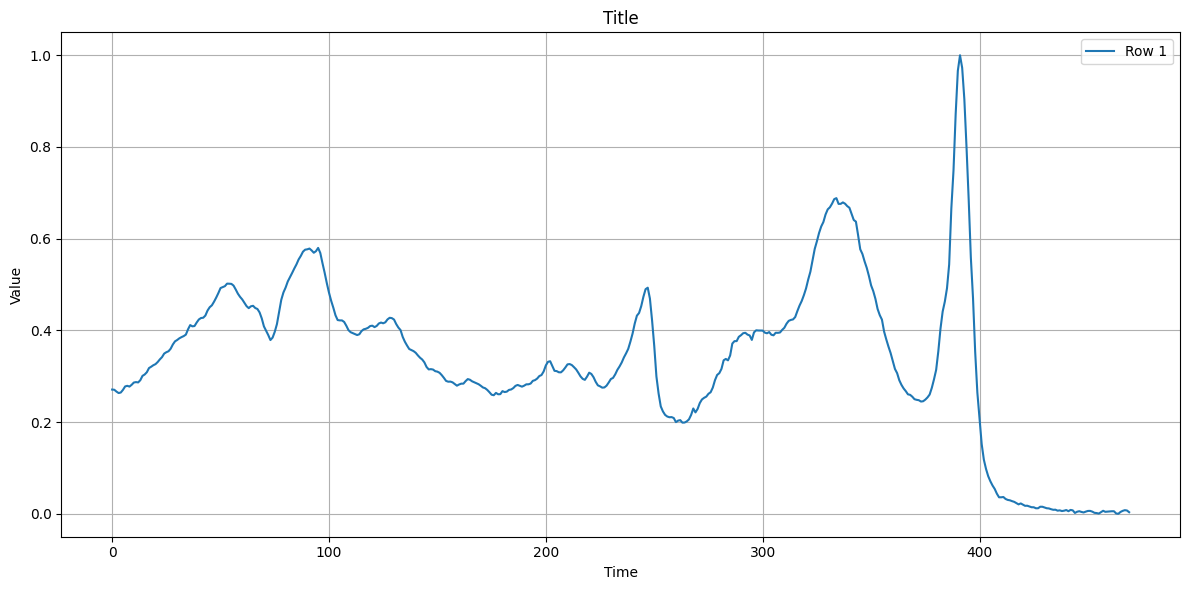

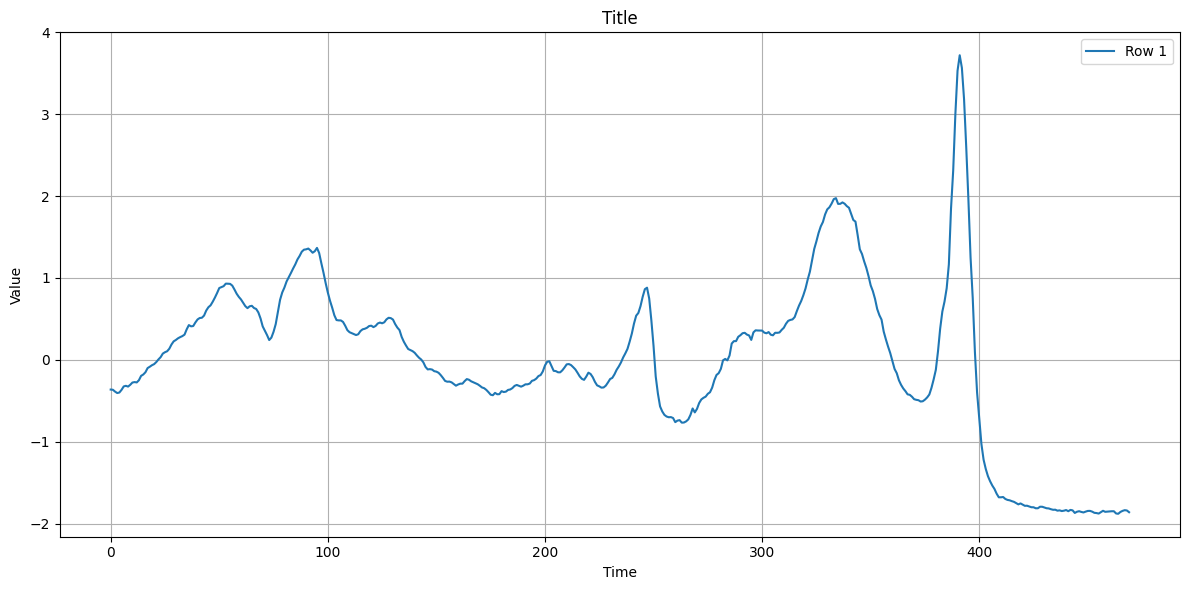

In [35]:
plot_series([pipeline.X_normalized[0]])
plot_series([pipeline.X[0]])

In [36]:
pipeline.extract_embeddings()

In [37]:
pipeline.cluster()

In [38]:
results = pipeline.evaluate()

[3 2 3 1 4 0 0 0 4 4 0 0 4 0 4 4 0 0 4 0 4 4 0 0 4 0 4 4 0 0 4 2 1 1 2 0 4
 0 4 3 0 0 4 0 4 0 0 0 4 0 4 4 0 0 0 0 4 4 0 0]



Clustering Results:
adjusted_rand_score: 0.0206
normalized_mutual_info_score: 0.1893
silhouette_score: 0.4205


/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


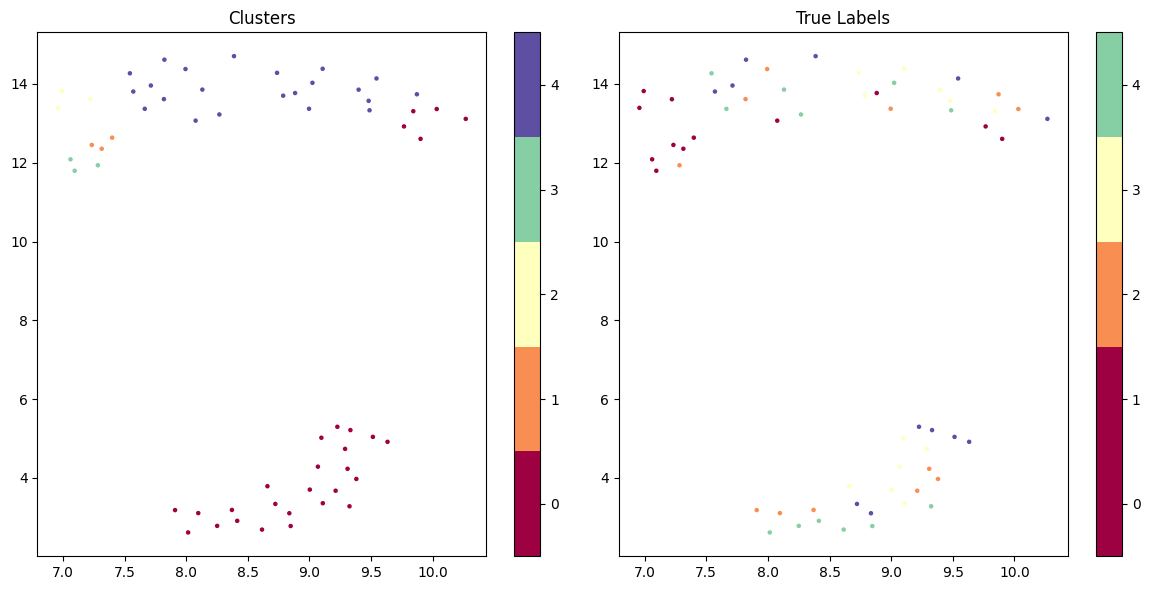

In [39]:
print("\nClustering Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")
    
pipeline.visualize()


Clustering Results:
adjusted_rand_score: 1.0000
normalized_mutual_info_score: 1.0000
silhouette_score: 0.7306


/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


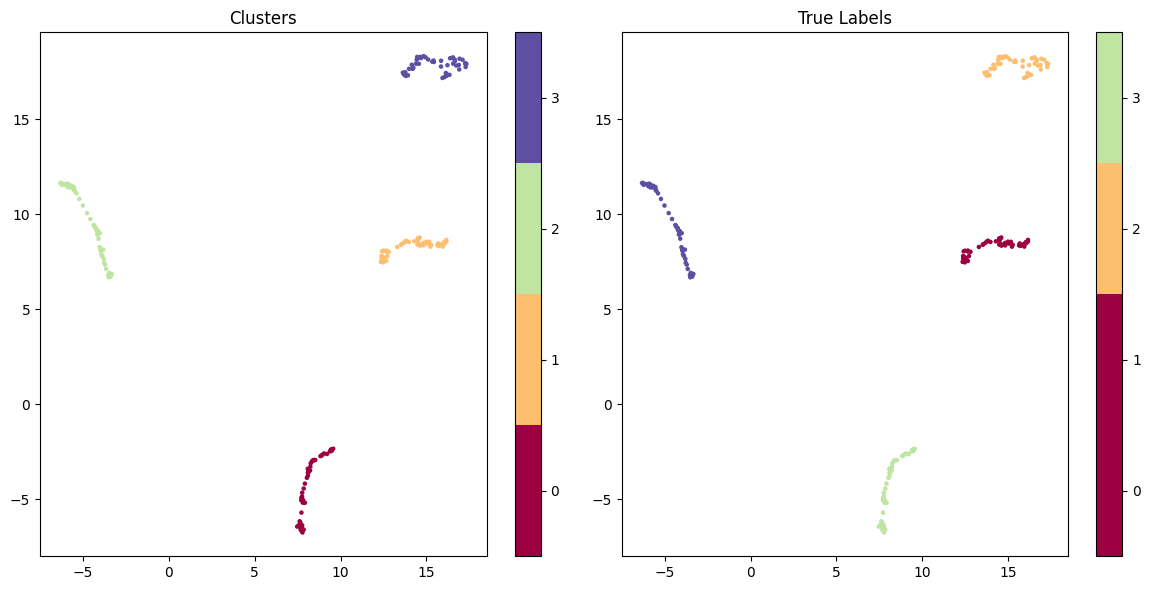

In [ ]:
print("\nClustering Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")
    
pipeline.visualize()